In [1]:
import time
from typing import Iterable

import np as np
import torch
from cgtasknet.instruments.instrument_subgroups import SubgroupFinder
from cgtasknet.tasks.reduce import ReduceTaskCognitive
from tqdm import tqdm


class EveryTaskSubgroups:
    device = torch.device("cpu")

    def __init__(
        self, model: torch.nn.Module, tasks: Iterable[ReduceTaskCognitive]
    ) -> None:
        self._tasks = tasks
        self._model = model
        self._subgroups_finder = []

    def run(self, number_of_trials: int, dt: float = 1e-3):
        self._subgroups_finder = []
        number_of_trials = int(number_of_trials)
        dt = float(dt)
        print("*" * 20, "Start")
        for current_task in self._tasks:
            t0 = time.perf_counter()
            self._subgroups_finder.append(SubgroupFinder(dt))
            for i in tqdm(range(number_of_trials)):
                status = False
                while not status:
                    inputs, t_outputs, s, out = self._run_trial(current_task)
                    status = self._subgroups_finder[-1].compute_average_freq(
                        [s.to(torch.device("cpu"))[50:]],
                        [inputs[:, 0, 0].to(torch.device("cpu"))[50:]],
                        [out.to(torch.device("cpu"))[50:]],
                        [t_outputs.to(torch.device("cpu"))[50:]],
                    )
            print(
                f"Complete task: {current_task.task_number}, time: {time.perf_counter() - t0}s"
            )

    def _run_trial(self, task: ReduceTaskCognitive):
        init_state = LIFAdExState(
            torch.zeros(batch_size, hidden_size).to(device),
            torch.rand(batch_size, hidden_size).to(device) * 1,
            torch.zeros(batch_size, hidden_size).to(device),
            torch.rand(batch_size, hidden_size).to(device) * 0.0,
        )
        inputs, t_outputs = task.dataset()
        inputs = torch.from_numpy(inputs).type(torch.float).to(self.device)
        t_outputs = torch.from_numpy(t_outputs).type(torch.float).to(self.device)
        out, _, s = self._model(inputs, init_state)
        s = torch.stack(s).detach()
        s = s.reshape((s.shape[0], s.shape[2]))
        return inputs, t_outputs, s, out

    def get_frequencies(self):
        fixation = []
        answer = []
        for subgoup_finder in self._subgroups_finder:
            t_fixation, t_answer = subgoup_finder.get_average_freq()
            fixation.append(t_fixation)
            answer.append(t_answer)
        return fixation, answer

In [2]:
import torch
from cgtasknet.tasks.reduce import (
    CtxDMTaskParameters,
    DMTaskParameters,
    DMTaskRandomModParameters,
    MultyReduceTasks,
    RomoTaskParameters,
    RomoTaskRandomModParameters,
    GoTaskParameters,
    GoTaskRandomModParameters,
    GoRtTaskParameters,
    GoRtTaskRandomModParameters,
    GoDlTaskParameters,
    GoDlTaskRandomModParameters,
)
import matplotlib.pyplot as plt

In [3]:
go_task_list_values = np.linspace(0, 1, 8)
batch_size = 1
number_of_tasks = 1
romo_parameters = RomoTaskRandomModParameters(
    romo=RomoTaskParameters(
        delay=0.2,
        positive_shift_delay_time=1.5,
        trial_time=0.2,
        positive_shift_trial_time=0.4,
        answer_time=0.25,
    ),
)
dm_parameters = DMTaskRandomModParameters(
    dm=DMTaskParameters(trial_time=0.3, positive_shift_trial_time=1.5, answer_time=0.25)
)
ctx_parameters = CtxDMTaskParameters(dm=dm_parameters.dm)
go_parameters = GoTaskRandomModParameters(
    go=GoTaskParameters(
        trial_time=0.3,
        positive_shift_trial_time=1.5,
        value=go_task_list_values,
        answer_time=0.5,
    )
)
gort_parameters = GoRtTaskRandomModParameters(
    go_rt=GoRtTaskParameters(
        trial_time=0.3,
        positive_shift_trial_time=1.5,
        answer_time=1.5,
        value=go_task_list_values,
    )
)
godl_parameters = GoDlTaskRandomModParameters(
    go_dl=GoDlTaskParameters(
        go=GoTaskParameters(
            trial_time=0.2,
            positive_shift_trial_time=0.4,
            answer_time=0.25,
            value=go_task_list_values,
        ),
        delay=0.2,
        positive_shift_delay_time=1.5,
    )
)
sigma = 0.5
tasks = [
    "RomoTask1",
    "RomoTask2",
    "DMTask1",
    "DMTask2",
    "CtxDMTask1",
    "CtxDMTask2",
    "GoTask1",
    "GoTask2",
    "GoRtTask1",
    "GoRtTask2",
    "GoDlTask1",
    "GoDlTask2",
]
task_dict = {
    tasks[0]: romo_parameters,
    tasks[1]: romo_parameters,
    tasks[2]: dm_parameters,
    tasks[3]: dm_parameters,
    tasks[4]: ctx_parameters,
    tasks[5]: ctx_parameters,
    tasks[6]: go_parameters,
    tasks[7]: go_parameters,
    tasks[8]: gort_parameters,
    tasks[9]: gort_parameters,
    tasks[10]: godl_parameters,
    tasks[11]: godl_parameters,
}

tasks_sequence = [
    MultyReduceTasks(
        tasks=task_dict,
        batch_size=batch_size,
        delay_between=0,
        enable_fixation_delay=True,
        task_number=i,
    )
    for i in range(len(tasks))
]

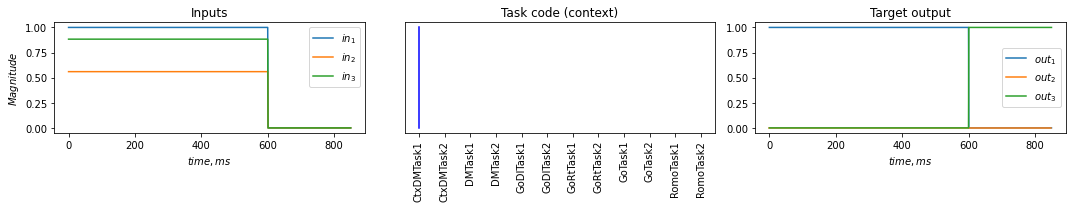

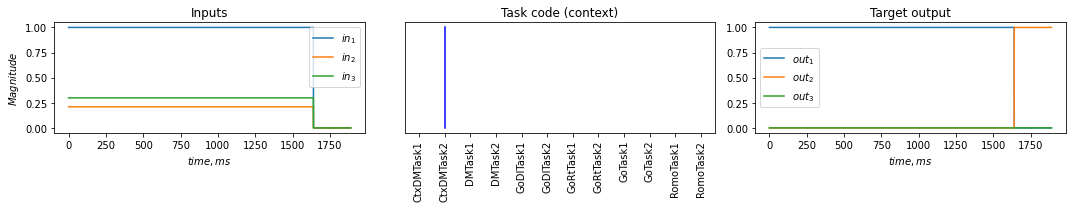

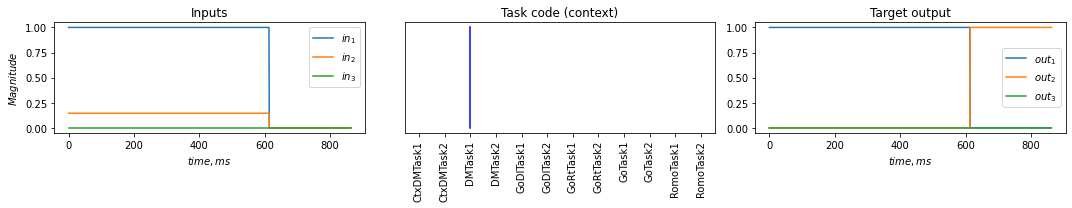

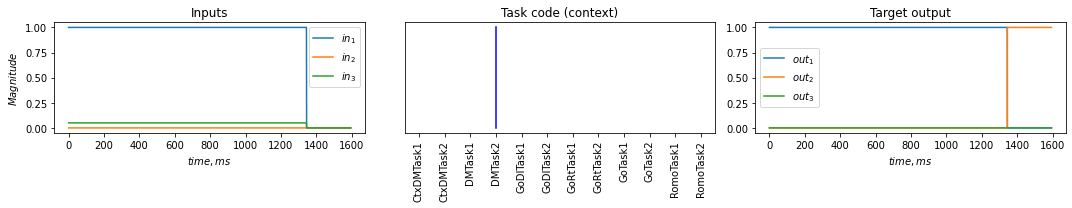

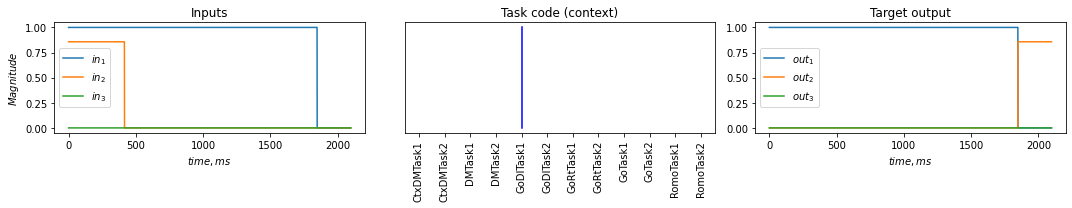

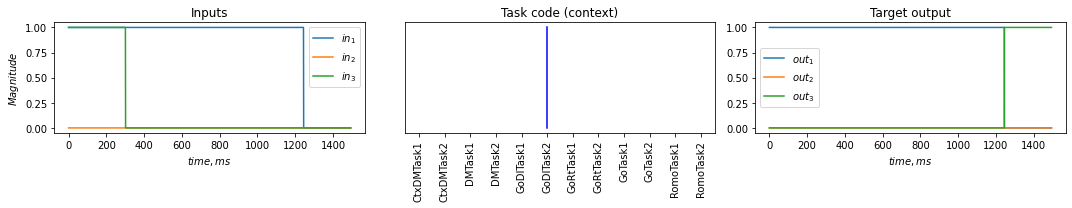

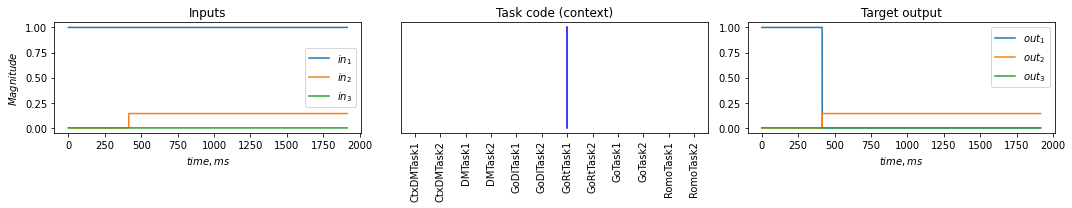

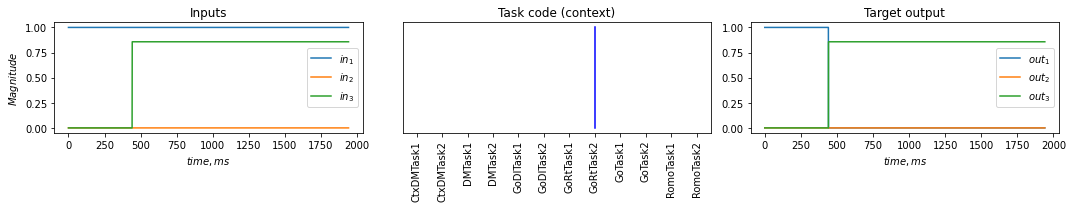

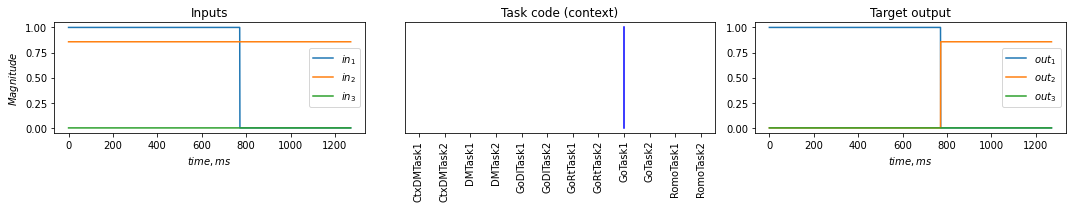

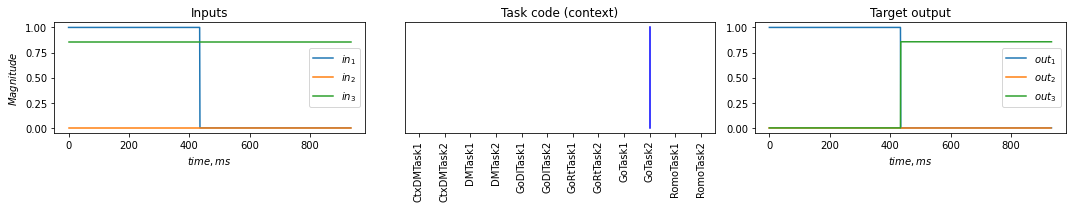

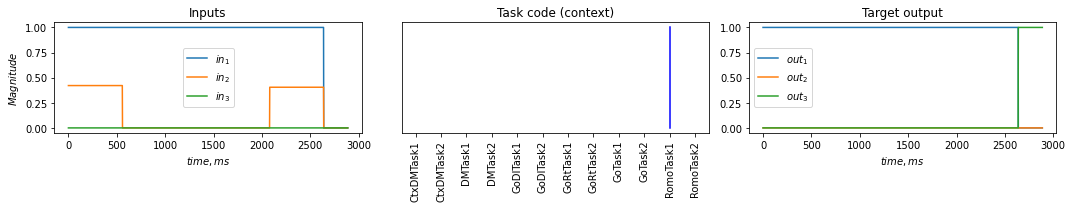

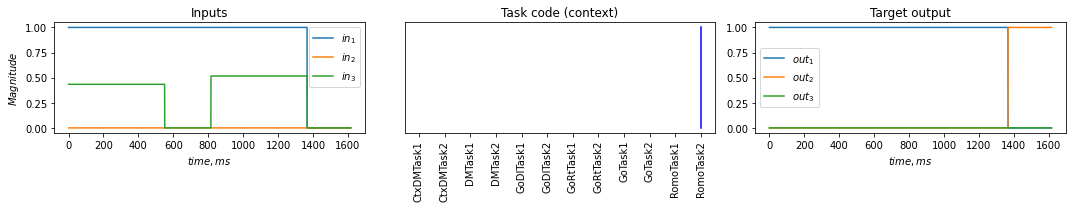

In [4]:
for task in tasks_sequence:
    inputs, t_outputs = task.dataset(n_trials=1)
    for batch in range(min(batch_size, 10)):
        fig = plt.figure(figsize=(15, 3))
    ax1 = fig.add_subplot(131)
    plt.title("Inputs")
    plt.xlabel("$time, ms$")
    plt.ylabel("$Magnitude$")
    for i in range(3):
        plt.plot(inputs[:, batch, i], label=rf"$in_{i + 1}$")
    plt.legend()
    plt.tight_layout()

    ax2 = fig.add_subplot(132)
    plt.title("Task code (context)")
    plt.xticks(range(1, len(tasks) + 1), sorted(tasks), rotation=90)
    plt.yticks([])
    for i in range(3, inputs.shape[-1]):
        plt.plot([i - 2] * 2, [0, inputs[0, batch, i]], c="b")
    plt.tight_layout()

    ax3 = fig.add_subplot(133)
    plt.title("Target output")
    plt.xlabel("$time, ms$")
    for i in range(t_outputs.shape[-1]):
        plt.plot(t_outputs[:, batch, i], label=rf"$out_{i + 1}$")
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()
    del inputs
    del t_outputs

In [5]:
from cgtasknet.net import SNNlifadex
from norse.torch import LIFAdExParameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
feature_size, output_size = tasks_sequence[0].feature_and_act_size
hidden_size = 256

neuron_parameters = LIFAdExParameters(
    v_th=torch.as_tensor(0.45),
    tau_ada_inv=1 / 2,
    alpha=100,
    method="super",
    # rho_reset = torch.as_tensor(5)
)
model = SNNlifadex(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=20,
    save_states=True,
    return_spiking=True,
).to(device)
model.load_state_dict(
    torch.load(
        r"A:\src\multy_task\models\low_freq\mean_fr_filter_less_v_th_0_45\weights\weights_100_N_256_without_square_2999_"
    )
)

<All keys matched successfully>

In [6]:
for name, param in model.named_parameters():
    if name == "alif.recurrent_weights":
        w_rec = torch.clone(param.detach().cpu())
    print(name)
for i in range(hidden_size):
    print(w_rec[i, i])

alif.input_weights
alif.recurrent_weights
exp_f.linear.weight
exp_f.linear.bias
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(

In [25]:
subgroups = EveryTaskSubgroups(model, tasks_sequence)
subgroups.device = device
subgroups.run(100)
fixations, answers = subgroups.get_frequencies()

******************** Start


100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


Complete task: 0, time: 45.55018430000001s


100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


Complete task: 1, time: 51.741950900000006s


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Complete task: 2, time: 41.15675059999995s


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Complete task: 3, time: 40.97812190000002s


100%|██████████| 100/100 [00:55<00:00,  1.82it/s]


Complete task: 4, time: 55.08534439999994s


100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


Complete task: 5, time: 56.13324260000002s


100%|██████████| 100/100 [01:30<00:00,  1.10it/s]


Complete task: 6, time: 90.87673309999991s


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


Complete task: 7, time: 88.65675050000004s


100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


Complete task: 8, time: 57.450189300000034s


100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Complete task: 9, time: 52.6936968s


100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


Complete task: 10, time: 73.71602110000003s


100%|██████████| 100/100 [01:22<00:00,  1.22it/s]

Complete task: 11, time: 82.29166780000014s


In [7]:
import os

folder = f"data/256_low_freq_filter_20_vth_0_45/"
if not os.path.exists(folder):
    os.mkdir(folder)
load_status = "load"
if load_status == "save":
    for i in range(len(fixations)):
        torch.save(fixations[i], f"{folder}/fixation_hists{i}")
        torch.save(answers[i], f"{folder}/answer_hists{i}")
elif load_status == "load":
    fixations, answers = [], []
    for i in range(len(tasks)):
        fixations.append(torch.load(f"{folder}/fixation_hists{i}"))
        answers.append(torch.load(f"{folder}/answer_hists{i}"))

In [27]:
torch.stack(fixations).sum(dim=0).sort().indices[-100:]

tensor([  9,  89,  62,  22, 120, 238, 110, 254, 240,  97,  17,  79, 166, 244,
        220, 225, 213,  23,  71,   7, 182, 106,  66,  98, 111,  58, 186, 136,
        140, 153, 212, 174, 196, 250, 171, 202, 101, 215,  95, 148, 243, 147,
         26, 127, 129, 194, 151, 160,  88, 167,  33, 251, 176,  36,  41,  10,
         16, 181,  52, 206,  55, 245, 102,  53, 131, 138,  40, 165, 125, 179,
         42, 122,   4, 146,   5, 139,  76, 149, 255, 163,  64,  63,  57, 217,
        232,  67, 104,  93,  61,  50,  12,  59, 231,  90, 193,  56, 164, 214,
        184, 107])

In [15]:
for name, params in model.named_parameters():
    print(f"{name=} {params.shape=}")

name='alif.input_weights' params.shape=torch.Size([600, 15])
name='alif.recurrent_weights' params.shape=torch.Size([600, 600])
name='exp_f.linear.weight' params.shape=torch.Size([3, 600])
name='exp_f.linear.bias' params.shape=torch.Size([3])


In [16]:
zeros_frequencies = set()
zeros_frequencies_answers = set()
zeros_frequencies_fixations = set()
threshold = 20
for i in range(len(fixations)):

    inter_section = set(torch.where(fixations[i] <= threshold)[0].numpy())
    inter_section = inter_section & set(torch.where(answers[i] <= threshold)[0].numpy())
    if len(zeros_frequencies) == 0:
        zeros_frequencies = inter_section
    else:
        zeros_frequencies = zeros_frequencies & inter_section

    if len(zeros_frequencies_fixations) == 0:
        zeros_frequencies_fixations = set(
            torch.where(fixations[i] <= threshold)[0].numpy()
        )
    else:
        zeros_frequencies_fixations = zeros_frequencies_fixations & set(
            torch.where(fixations[i] <= threshold)[0].numpy()
        )

    if len(zeros_frequencies_answers) == 0:
        zeros_frequencies_answers = set(torch.where(answers[i] <= threshold)[0].numpy())
    else:
        zeros_frequencies_answers = zeros_frequencies_answers & set(
            torch.where(answers[i] <= threshold)[0].numpy()
        )
len(zeros_frequencies)

266

In [17]:
print(zeros_frequencies_answers)
print(zeros_frequencies_fixations)

{1, 2, 5, 6, 8, 10, 12, 14, 18, 19, 20, 22, 23, 24, 26, 28, 29, 30, 32, 33, 35, 36, 38, 39, 40, 42, 43, 44, 45, 49, 51, 53, 54, 56, 57, 58, 60, 61, 62, 65, 66, 67, 69, 70, 71, 73, 74, 75, 76, 77, 80, 88, 89, 93, 94, 95, 96, 97, 100, 101, 102, 104, 106, 107, 108, 109, 112, 113, 115, 116, 117, 118, 120, 121, 122, 124, 127, 128, 130, 131, 137, 138, 140, 145, 148, 149, 150, 151, 152, 154, 157, 158, 159, 160, 161, 163, 164, 165, 166, 167, 169, 172, 173, 174, 176, 184, 185, 186, 187, 188, 190, 191, 192, 193, 194, 195, 198, 201, 202, 205, 206, 207, 208, 209, 213, 215, 218, 222, 223, 226, 227, 229, 230, 233, 234, 236, 237, 238, 240, 243, 246, 251, 252, 255, 256, 257, 260, 261, 262, 264, 265, 267, 268, 270, 273, 274, 276, 277, 282, 286, 291, 293, 294, 296, 300, 301, 302, 303, 304, 312, 314, 315, 316, 317, 319, 324, 326, 327, 328, 330, 331, 334, 335, 338, 339, 340, 347, 348, 351, 352, 353, 355, 356, 360, 361, 362, 363, 365, 367, 368, 374, 377, 378, 379, 380, 382, 383, 385, 392, 393, 394, 399, 40

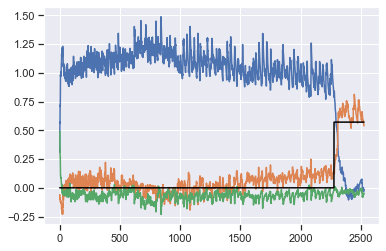

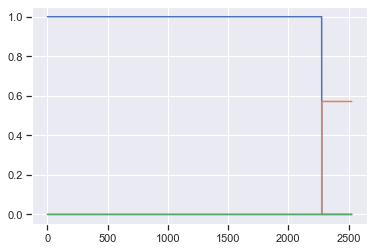

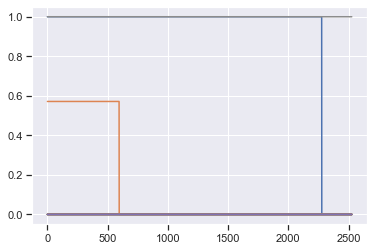

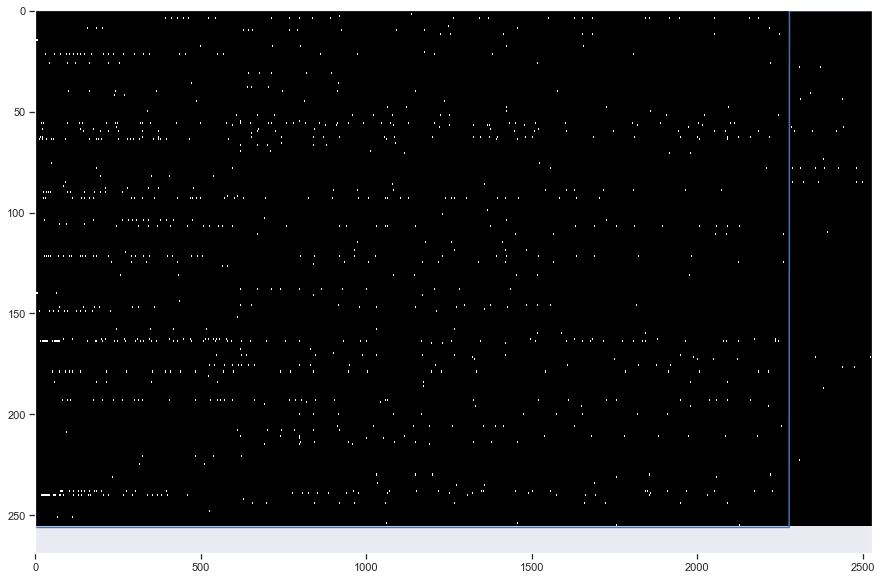

In [27]:
from norse.torch import LIFAdExState
from matplotlib import colors

inputs, t_outputs = tasks_sequence[4].dataset(1)
inputs = torch.from_numpy(inputs).type(torch.float).to(device)
# inputs = torch.zeros((3000, 1, feature_size)).to(device)
init_state = LIFAdExState(
    torch.zeros(batch_size, hidden_size).to(device),
    torch.rand(batch_size, hidden_size).to(device) * 1,
    torch.zeros(batch_size, hidden_size).to(device),
    torch.rand(batch_size, hidden_size).to(device) * 0.0,
)
outputs, states, s = model(inputs, init_state)
plt.plot(outputs[:, 0, 0].detach().cpu())
plt.plot(outputs[:, 0, 1].detach().cpu())

plt.plot(outputs[:, 0, 2].detach().cpu())
plt.plot(t_outputs[:, 0, 1], c="black")
plt.figure()
plt.plot(t_outputs[:, 0, :])
plt.figure()
plt.plot(inputs[:, 0, :].cpu())

plt.show()
plt.close()
if isinstance(s, list):
    s = torch.concat(s)
s = s.detach().cpu()
cmap = colors.ListedColormap(["black", "white"])
bounds = [0, 1]
norm = colors.BoundaryNorm(bounds, cmap.N)
plt.figure(figsize=(15, 10))
plt.imshow(s[:, :].T, aspect="auto", interpolation="nearest", cmap=cmap, norm=norm)
plt.grid(False)
plt.plot(inputs[:, 0, 0].cpu() * hidden_size)
plt.show()
plt.close()

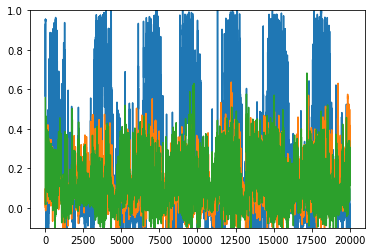

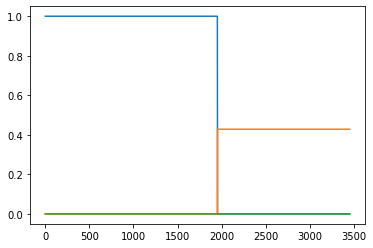

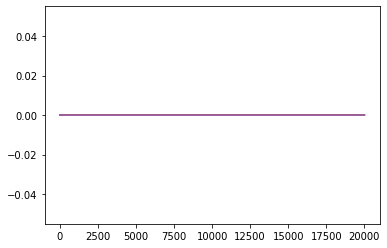

In [19]:
inputs = torch.zeros((20000, 1, feature_size)).to(device)
init_state = LIFAdExState(
    torch.zeros(batch_size, hidden_size).to(device),
    torch.rand(batch_size, hidden_size).to(device) * 1.0,
    torch.zeros(batch_size, hidden_size).to(device),
    torch.rand(batch_size, hidden_size).to(device) * 0.0,
)
outputs, states, s = model(inputs, init_state)

plt.plot(outputs[:, 0, 0].detach().cpu())
plt.plot(outputs[:, 0, 1].detach().cpu())
plt.plot(outputs[:, 0, 2].detach().cpu())
plt.ylim([-0.1, 1])
plt.figure()
plt.plot(t_outputs[:, 0, :])
plt.figure()
plt.plot(inputs[:, 0, :].cpu())

In [17]:
v = []
a = []
for i in range(len(states)):
    v.append(states[i].v)
    a.append(states[i].a)

In [18]:
if isinstance(v, list):
    v = torch.concat(v).detach().cpu()
if isinstance(a, list):
    a = torch.concat(a).detach().cpu()

In [19]:
for name, params in model.named_parameters():
    if name == "alif.recurrent_weights":
        w_rec = params.detach().cpu()

In [20]:
torch.sum(w_rec[fixations[0].argmin().item(), :])

tensor(-33.8022)

In [21]:
fixations[0].max()

tensor(999.9999)

In [22]:
isinstance(s, list)

True

In [23]:
from norse.torch import LIFAdExState

inputs = torch.zeros((20000, 1, feature_size)).to(device)
number_of_loop = 1
sum_s = None
count = 0
for i in tqdm(range(number_of_loop)):
    init_state = LIFAdExState(
        torch.zeros(batch_size, hidden_size).to(device),
        torch.rand(batch_size, hidden_size).to(device) * 1,
        torch.zeros(batch_size, hidden_size).to(device),
        torch.rand(batch_size, hidden_size).to(device) * 0,
    )
    outputs = model(inputs, init_state)
    s = torch.concat(outputs[-1][10000:], dim=0).cpu().detach()
    if sum_s is None:
        sum_s = torch.sum(s, dim=0)
    else:
        sum_s += torch.sum(s, dim=0)
    count += len(s)
mean_zero_input = sum_s / count / number_of_loop / 1e-3

100%|██████████| 1/1 [00:06<00:00,  6.41s/it]


In [9]:
import numpy as np


def plot_hist(data, c="#003153", alpha=1):
    x = np.arange(0, len(data), 1)
    for i in range(len(data)):
        plt.plot([x[i]] * 2, [0, data[i]], c=c, alpha=alpha, linewidth=0.5)

In [10]:
for name, params in model.named_parameters():
    if name == "exp_f.linear.weight":
        out_weights = torch.clone(params.detach()).cpu()

In [11]:
for name, params in model.named_parameters():
    print(name)
    if name == "alif.input_weights":
        weights = torch.clone(params.detach()).cpu()
    if name == "exp_f.linear.weight":
        out_weights = torch.clone(params.detach()).cpu()

alif.input_weights
alif.recurrent_weights
exp_f.linear.weight
exp_f.linear.bias


In [12]:
from cgtasknet.instruments.instrument_subgroups import sort_elemnts_by_another

fixation_by_fixation_out = [
    fixations[i] * out_weights[0, :] for i in range(len(fixations))
]
fixation_by_first_out = [
    fixations[i] * out_weights[1, :] for i in range(len(fixations))
]
answer_by_first_out = [answers[i] * out_weights[1, :] for i in range(len(answers))]

fixation_sort_by_first = [sort_elemnts_by_another(fixations[0], el) for el in fixations]
answer_sort_by_fixation = [sort_elemnts_by_another(fixations[0], el) for el in answers]

answer_sort_by_first = [sort_elemnts_by_another(answers[0], el) for el in answers]

fixation_sort_by_first_strength = [
    sort_elemnts_by_another(answer_by_first_out[0], el) for el in fixations
]
answer_sort_by_first_strength = [
    sort_elemnts_by_another(answer_by_first_out[0], el) for el in answers
]

fixation_strength_by_answer_strength_sort = [
    sort_elemnts_by_another(answer_by_first_out[0], el) for el in fixation_by_first_out
]

answer_strength_by_answer_strength_sort = [
    sort_elemnts_by_another(answer_by_first_out[0], el) for el in answer_by_first_out
]

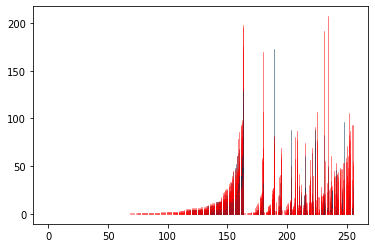

In [11]:
for i in range(len(fixations)):
    plot_hist(answer_sort_by_fixation[i])
    plot_hist(fixation_sort_by_first[i], c="r")

plt.show()
plt.close()

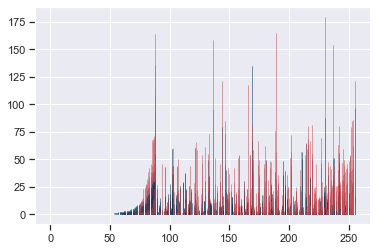

In [30]:
for i in range(len(fixations)):
    plot_hist(answer_sort_by_fixation[i])
    plot_hist(fixation_sort_by_first[i], c="r")

plt.show()

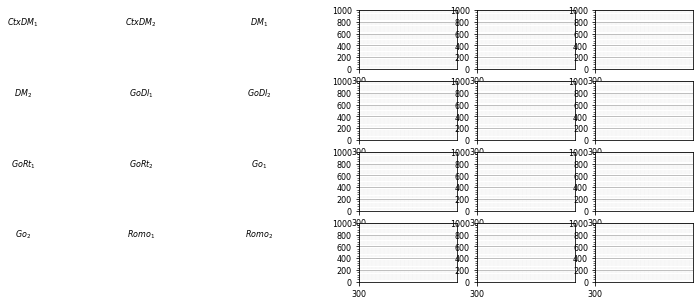

In [17]:
plt.rcParams["font.size"] = 8
sorted_tasks = sorted(tasks)
plt.figure(figsize=(6, 5))
axes = []
for i in range(len(fixations)):
    ax = plt.subplot(4, 3, i + 1)
    axes.append(ax)
    plot_hist(answer_sort_by_fixation[i])
    plot_hist(fixation_sort_by_first[i], c="r")
    # plot_hist(answer_sort_by_fixation[i] - fixation_sort_by_first[i], c='g')
    # plt.title(sorted_tasks[i].replace('Task', ''))
    plt.grid()
    plt.minorticks_on()
    plt.grid(which="minor", linestyle="--", linewidth=0.25)
    plt.ylim(0, 1000)
    ax.set_xlim(300, hidden_size)
    plt.text(
        s=f"${sorted_tasks[i].replace('Task', '')[:-1:1]}_{sorted_tasks[i][-1]}$",
        x=450,
        y=800,
        ha="center",
        bbox={"facecolor": "white", "alpha": 1, "edgecolor": "none", "pad": 1},
        va="center",
    )
    ax.set_xticks([*range(300, hidden_size + 100, 100)])
    ax.set_xticks([*range(300, hidden_size + 10, 10)], minor=True)
    ax.set_yticks([*range(0, 1200, 200)])
    ax.set_yticks([*range(0, 1040, 40)], minor=True)

# [axes[i].set_ylabel('F, Hz') for i in range(0, len(axes), 3)]
# [axes[i].set_xlabel('Neuron number') for i in range(9, len(axes))]
# plt.tight_layout()
# plt.savefig('answer_and_fixations_freq.eps')
plt.show()
plt.close()

In [23]:
np.concatenate((["1", "2s"], ["2"]))

array(['1', '2s', '2'], dtype='<U2')

In [13]:
import seaborn as sns
import pandas as pd

sorted_tasks = sorted(tasks)
data = pd.DataFrame(
    {
        "Data": np.concatenate(
            (
                np.concatenate(fixation_sort_by_first),
                np.concatenate(answer_sort_by_fixation),
            )
        ),
        "Task": np.concatenate(
            [
                [f"${el.replace('Task', '')[:-1:1]}_{el[-1]}$"] * hidden_size
                for el in sorted_tasks
            ]
            * 2
        ),
        "Stage": np.concatenate(
            (
                np.array(["Fixation"] * len(sorted_tasks) * hidden_size),
                ["Answer"] * len(sorted_tasks) * hidden_size,
            )
        ),
        "x": np.array([*range(hidden_size)] * len(sorted_tasks) * 2),
    }
)
data

,Data,Task,Stage,x
0,0.000000,$CtxDM_1$,Fixation,0
1,0.000000,$CtxDM_1$,Fixation,1
2,0.000000,$CtxDM_1$,Fixation,2
3,0.000000,$CtxDM_1$,Fixation,3
4,0.000000,$CtxDM_1$,Fixation,4
...,...,...,...,...
6139,0.642570,$Romo_2$,Answer,251
6140,0.642570,$Romo_2$,Answer,252
6141,0.000000,$Romo_2$,Answer,253
6142,0.602410,$Romo_2$,Answer,254


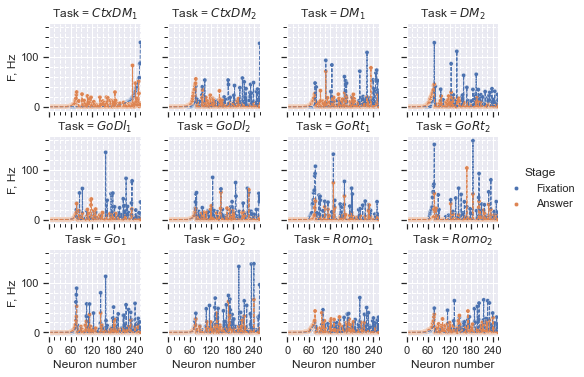

In [14]:
plt.rcParams["font.size"] = 8
plt.ioff()
sns.set(rc={"xtick.bottom": True, "ytick.left": True})

g = sns.FacetGrid(
    data,
    col="Task",
    hue="Stage",
    margin_titles=True,
    height=1.8,
    col_wrap=4,
    palette="deep",
)
g.map(sns.lineplot, "x", "Data", linewidth=1, linestyle="--")
ax = g.map(sns.scatterplot, "x", "Data", size=0.1)
g.set_axis_labels("Neuron number", "F, Hz")
# g.set(xticks=[10, 30, 50], yticks=[2, 6, 10])
g.figure.subplots_adjust(wspace=0.3, hspace=0.3)
g.set(
    xticks=[*range(0, hidden_size + 60, 60)],
    xlim=[0, 256],
)
plt.minorticks_on()
for axes in g.axes.flat:
    # axes.set_yticks(which='minor', ticks=[*range(0, 1200, 200)], alpha=1, )
    axes.grid(which="minor", linestyle="--")
g.add_legend()
plt.savefig("256_answer_and_fixations_freq.eps")

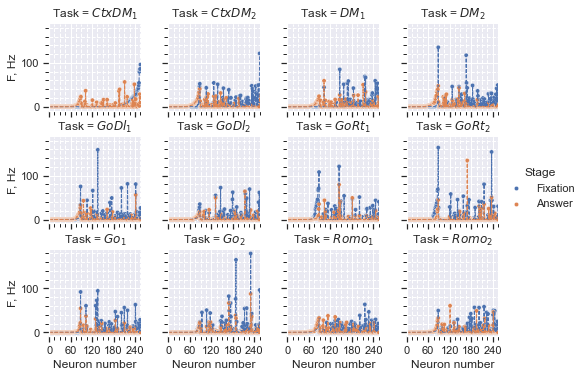

In [44]:
plt.rcParams["font.size"] = 8
plt.ioff()
sns.set(rc={"xtick.bottom": True, "ytick.left": True})

g = sns.FacetGrid(
    data,
    col="Task",
    hue="Stage",
    margin_titles=True,
    height=1.8,
    col_wrap=4,
    palette="deep",
)
g.map(sns.lineplot, "x", "Data", linewidth=1, linestyle="--")
ax = g.map(sns.scatterplot, "x", "Data", size=0.1)
g.set_axis_labels("Neuron number", "F, Hz")
# g.set(xticks=[10, 30, 50], yticks=[2, 6, 10])
g.figure.subplots_adjust(wspace=0.3, hspace=0.3)
g.set(
    xticks=[*range(0, hidden_size + 60, 60)],
    xlim=[0, 256],
)
plt.minorticks_on()
for axes in g.axes.flat:
    # axes.set_yticks(which='minor', ticks=[*range(0, 1200, 200)], alpha=1, )
    axes.grid(which="minor", linestyle="--")
g.add_legend()
plt.savefig("256_answer_and_fixations_freq.eps")
plt.savefig("256_answer_and_fixations_freq.svg")
plt.show()

In [330]:
plt.show()

In [244]:
g.palette = "rocket"
g.saturation = 1
g.dodge = False

g.set(
    xticks=[*range(0, hidden_size + 100, 20)],
    yticks=[*range(0, 1200, 200)],
    xlim=[300, 600],
    ylim=[0, 1000],
    alpha=1,
)
plt.draw()

In [207]:
% matplotlib
plt.ion()
g = sns.catplot(
    x="x",
    y="Data",
    hue="Type",
    col="Task",
    col_wrap=4,
    data=data,
    kind="bar",
    height=4,
    aspect=0.7,
    lw=0.5,
)
plt.show()

Using matplotlib backend: TkAgg


In [221]:
g.set(
    xticks=[*range(0, hidden_size + 100, 100)],
    yticks=[*range(0, 1200, 200)],
    xlim=[300, 600],
    ylim=[0, 1000],
)
g.pallet = "Dark"
g.lw = 40.10
g.set_axis_labels("Neuron number", "F, Hz")
plt.draw()
# plt.show()

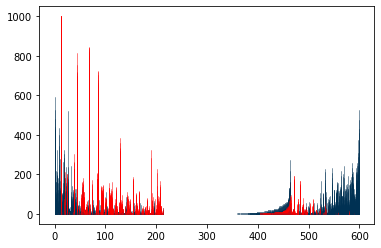

In [39]:
for i in range(len(fixations)):
    plot_hist(answer_sort_by_first_strength[i])
    plot_hist(fixation_sort_by_first_strength[i], c="r")

plt.show()
plt.close()

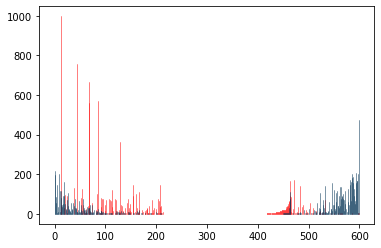

In [38]:
index = 1

plot_hist(fixation_sort_by_first_strength[index], c="r")
plot_hist(answer_sort_by_first_strength[index])

In [158]:
zeros_inputs_sort_by_fixation = sort_elemnts_by_another(
    answer_by_first_out[0], mean_zero_input
)

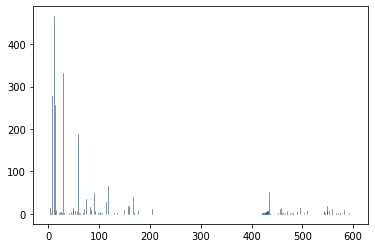

In [159]:
plot_hist(zeros_inputs_sort_by_fixation)

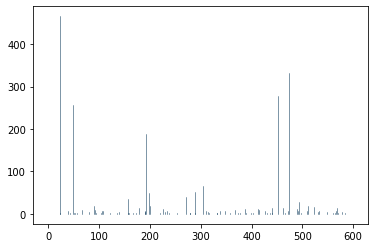

In [160]:
plot_hist(mean_zero_input)

# Сортировка частот во время интервала фиксации по первому графику (т.е. по задаче CtxDMTask1)

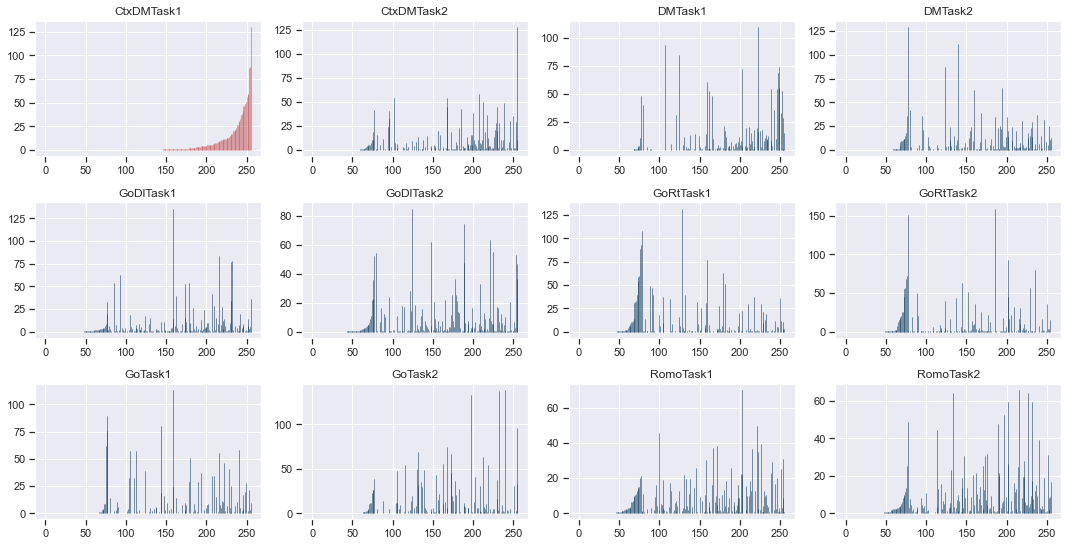

In [17]:
fig = plt.figure(figsize=(15, 10))
for i in range(len(fixation_sort_by_first)):
    plt.subplot(4, 4, i + 1)
    plt.title(sorted(tasks)[i])
    if i == 0:
        plot_hist(fixation_sort_by_first[i], c="r")
    else:
        plot_hist(fixation_sort_by_first[i])
    plt.tight_layout()
plt.show()
plt.close()

# Сортировка частот во время отклика по первому графику (т.е. по CtxDMTask1)

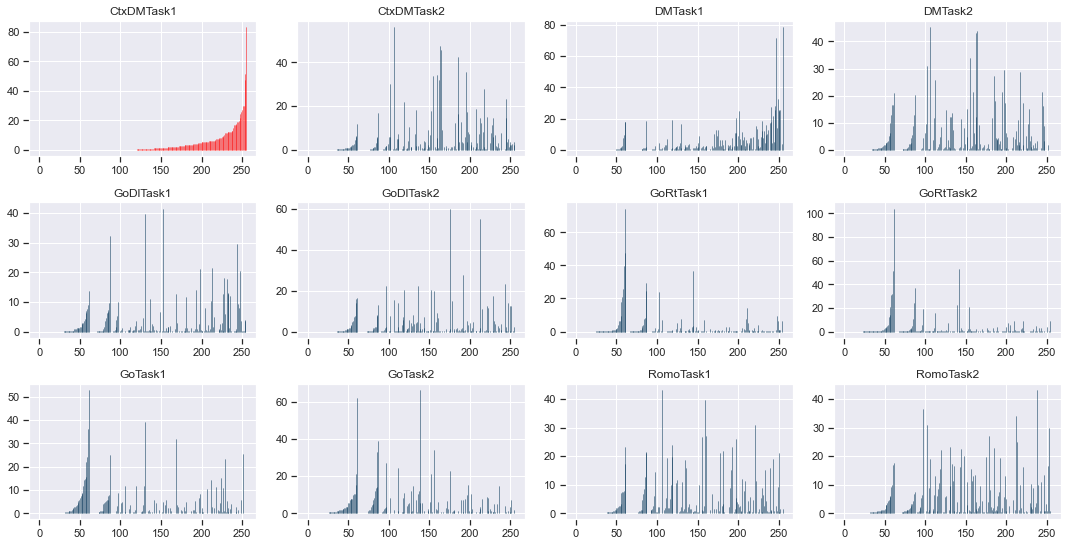

In [16]:
fig = plt.figure(figsize=(15, 10))
for i in range(len(answer_sort_by_first)):
    plt.subplot(4, 4, i + 1)
    plt.title(sorted(tasks)[i])
    plot_hist(answer_sort_by_first[i], c="red" if i == 0 else "#003153")
    plt.tight_layout()
plt.show()
plt.close()

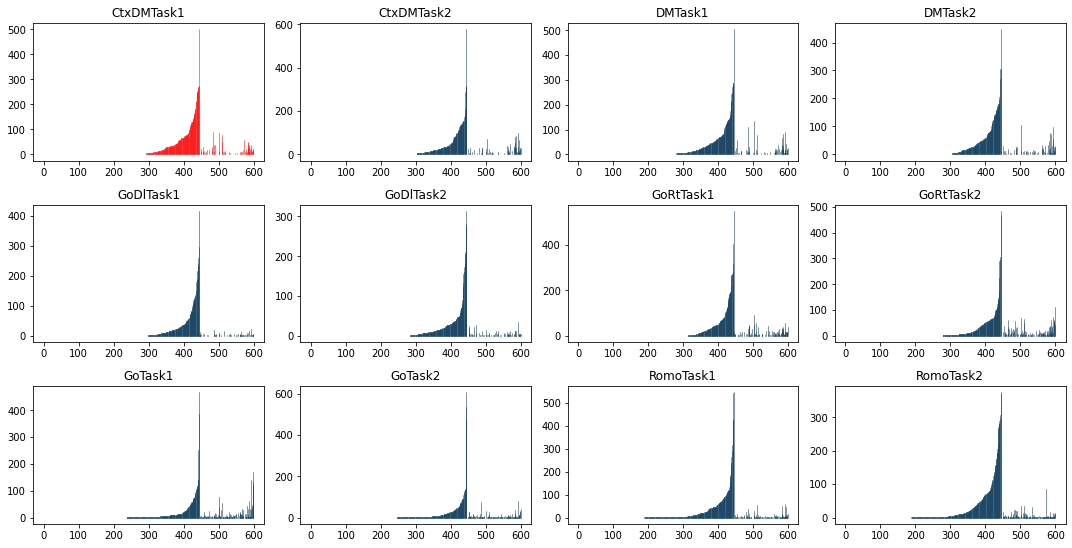

In [34]:
fig = plt.figure(figsize=(15, 10))
for i in range(len(answer_sort_by_fixation)):
    plt.subplot(4, 4, i + 1)
    plt.title(sorted(tasks)[i])
    plot_hist(answer_sort_by_fixation[i], c="red" if i == 0 else "#003153")
    plt.tight_layout()
plt.show()
plt.close()

# Сортировка частот во время фиксации по вкладу в первый выход (активный выход)

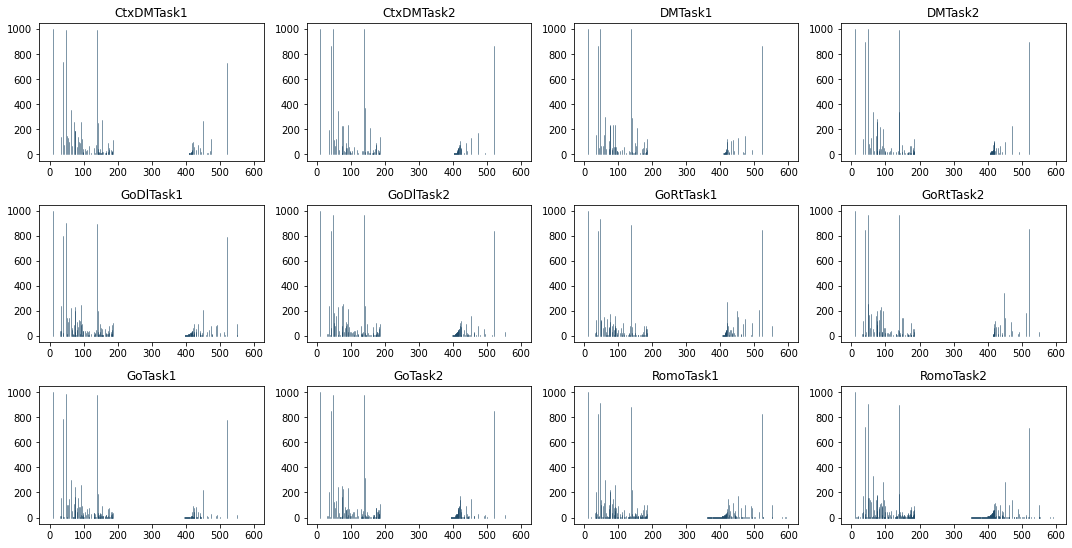

In [35]:
fig = plt.figure(figsize=(15, 10))
for i in range(len(fixation_sort_by_first_strength)):
    plt.subplot(4, 4, i + 1)
    plt.title(sorted(tasks)[i])
    plot_hist(fixation_sort_by_first_strength[i])
    plt.tight_layout()
plt.show()
plt.close()

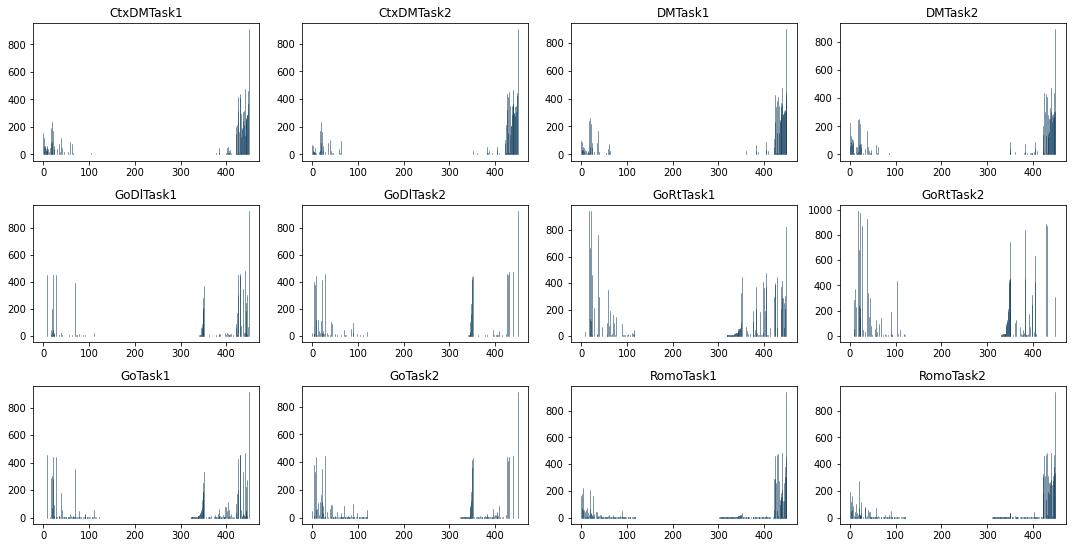

In [16]:
fig = plt.figure(figsize=(15, 10))
for i in range(len(answer_sort_by_first_strength)):
    plt.subplot(4, 4, i + 1)
    plt.title(sorted(tasks)[i])
    plot_hist(answer_sort_by_first_strength[i])
    plt.tight_layout()
plt.show()
plt.close()

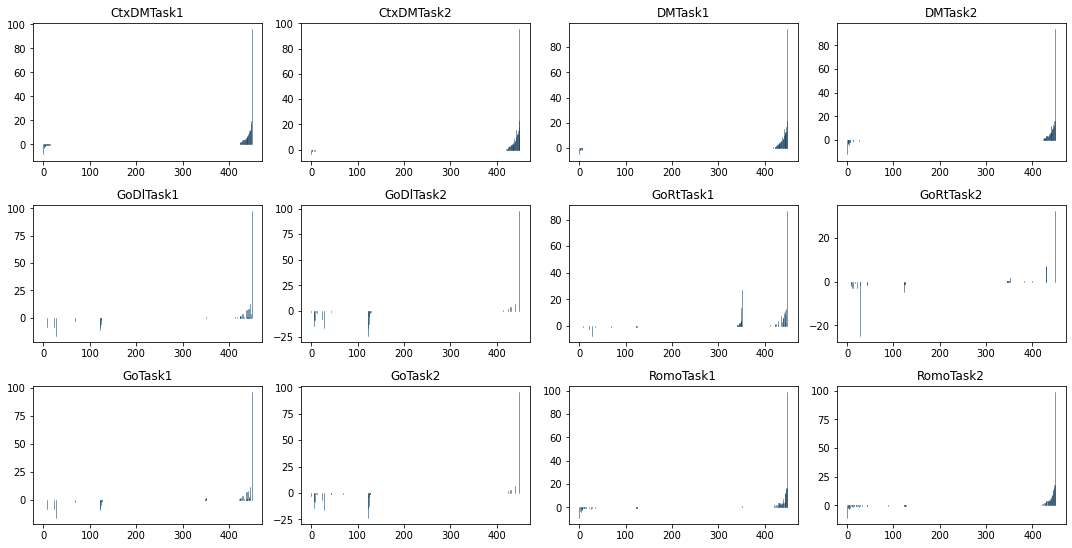

In [17]:
fig = plt.figure(figsize=(15, 10))
for i in range(len(answer_strength_by_answer_strength_sort)):
    plt.subplot(4, 4, i + 1)
    plt.title(sorted(tasks)[i])
    plot_hist(answer_strength_by_answer_strength_sort[i])
    plt.tight_layout()
plt.show()
plt.close()

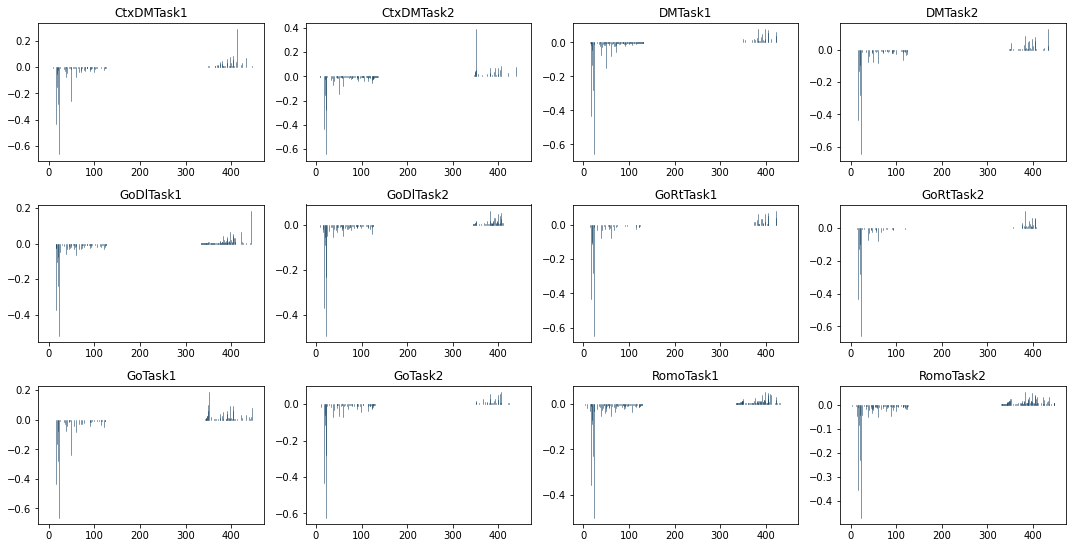

In [18]:
fig = plt.figure(figsize=(15, 10))
for i in range(len(fixation_strength_by_answer_strength_sort)):
    plt.subplot(4, 4, i + 1)
    plt.title(sorted(tasks)[i])
    plot_hist(fixation_strength_by_answer_strength_sort[i])
    plt.tight_layout()
plt.show()
plt.close()

In [36]:
indexes_for_sort = [*range(hidden_size)]
indexes_for_sort = sort_elemnts_by_another(fixations[-2], indexes_for_sort)

In [33]:
fixations_group_mean = np.zeros_like(fixations[0])
for fixation in fixations:
    fixations_group_mean += fixation.numpy()

fixations_group_mean /= len(fixations)

answers_group_mean = np.zeros_like(answers[0])
for answer in answers:
    answers_group_mean += answer.numpy()

answers_group_mean /= len(answers)

In [34]:
indexes_for_sort_fixation = [*range(hidden_size)]
indexes_for_sort_answer = [*range(hidden_size)]
indexes_for_sort_fixation = sort_elemnts_by_another(fixations_group_mean, indexes_for_sort_fixation).numpy()
indexes_for_sort_answer = sort_elemnts_by_another(answers_group_mean, indexes_for_sort_answer).numpy()
for name, params in model.named_parameters():
    if name == "alif.input_weights":
        weights = torch.clone(params.detach()).cpu().numpy()
weights = [weights[:, i] for i in range(0, 3)]
weights_sort_by_fixation = [np.zeros_like(el) for el in weights]
weights_sort_by_answer = [np.zeros_like(el) for el in weights]
for i in range(len(weights_sort_by_fixation)):
    for j in range(hidden_size):
        weights_sort_by_answer[i][j] = weights[i][indexes_for_sort_answer[j]] *
                                       answers_group_mean[indexes_for_sort_answer][0]
    weights_sort_by_fixation[i][j] = weights[i][indexes_for_sort_fixation[j]] *
                                     fixations_group_mean[indexes_for_sort_fixation][0]
print(1)

1


In [35]:
answers_group_mean.shape

(256,)

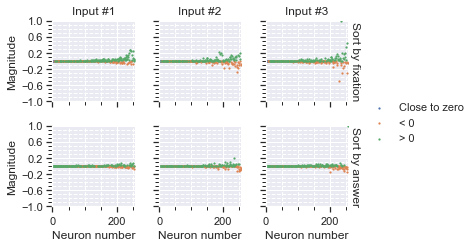

In [42]:
indexes_for_sort_fixation = [*range(hidden_size)]
indexes_for_sort_answer = [*range(hidden_size)]
indexes_for_sort_fixation = sort_elemnts_by_another(
    fixations_group_mean, indexes_for_sort_fixation
)
indexes_for_sort_answer = sort_elemnts_by_another(
    answers_group_mean, indexes_for_sort_answer
)

for name, params in model.named_parameters():
    if name == "alif.input_weights":
        weights = torch.clone(params.detach()).cpu().numpy()
weights = [weights[:, i] for i in range(0, 3)]
weights_sort_by_fixation = [np.zeros_like(el) for el in weights]
weights_sort_by_answer = [np.zeros_like(el) for el in weights]
for i in range(len(weights_sort_by_fixation)):
    for j in range(hidden_size):
        weights_sort_by_answer[i][j] = (
            weights[i][indexes_for_sort_answer[j]]
            * answers_group_mean[indexes_for_sort_answer[j]]
        )
        weights_sort_by_fixation[i][j] = (
            weights[i][indexes_for_sort_fixation[j]]
            * fixations_group_mean[indexes_for_sort_fixation[j]]
        )
    # max_divider = max(np.abs(weights_sort_by_fixation[i]).max(), np.abs(weights_sort_by_answer[i]).max())
    # weights_sort_by_fixation[i] /= max_divider
    # weights_sort_by_answer[i] /= max_divider
merge_weights = np.concatenate(
    (np.concatenate(weights_sort_by_fixation), np.concatenate(weights_sort_by_answer))
)
merge_weights[: len(merge_weights) // 2] /= merge_weights[
    : len(merge_weights) // 2
].max()
merge_weights[len(merge_weights) // 2 :] /= merge_weights[
    len(merge_weights) // 2 :
].max()
hue = (
    -(abs(merge_weights) > 1e-5).astype("int")
    + (abs(merge_weights) <= 1e-5).astype("int")
    - (merge_weights < -1e-5).astype("int")
)
hue_str = np.array(["Closed to zero"] * hue.shape[0])
hue_str[np.where(hue == -2)] = "< 0"
hue_str[np.where(hue == -1)] = "> 0"
hue_str[np.where(hue == 1)] = "Close to zero"
sorted_input_weights = pd.DataFrame(
    {
        "Data": merge_weights,
        "Sort by": ["fixation"] * len(weights_sort_by_fixation) * hidden_size
        + ["answer"] * len(weights_sort_by_fixation) * hidden_size,
        "Name": (["1"] * hidden_size + ["2"] * hidden_size + ["3"] * hidden_size) * 2,
        "Hue": hue_str,
        "x": [*range(hidden_size)] * len(weights_sort_by_fixation) * 2,
    }
)
sns.set(rc={"xtick.bottom": True, "ytick.left": True})

g = sns.FacetGrid(
    sorted_input_weights,
    col="Name",
    hue="Hue",
    row="Sort by",
    margin_titles=True,
    height=1.8,
    palette="deep",
)
# ax = g.map(sns.barplot, "x", "Data", order=sorted_input_weights.x.unique())
# ax = g.map(sns.lineplot, "x", "Data", linewidth=1, linestyle='--')\
ax = g.map(sns.scatterplot, "x", "Data", s=5.0, linewidth=0.0)
g.set_axis_labels("Neuron number", "Magnitude")
g.figure.subplots_adjust(wspace=0.3, hspace=0.3)
# g.set(xticks=[*range(0, hidden_size + 100, 100)], yticks=[*range(0, 1501, 500)], xlim=[300, 600], ylim=[0, 1000])
plt.minorticks_on()
for axes in g.axes.flat:
    axes.set_yticks(
        which="minor",
        ticks=np.arange(-1, 1.4, 0.4),
        alpha=1,
    )
    axes.set_xticks(
        which="minor",
        ticks=np.arange(0, 800, 200),
    )
    axes.set_ylim(-1, 1)
    axes.set_xlim(0, hidden_size)
    axes.grid(which="minor", linestyle="--")
g.add_legend()
g.set_titles(col_template="Input #{col_name}", row_template="Sort by {row_name}")
g.legend.set_title("")
plt.savefig("Input_sort.eps")

plt.show()

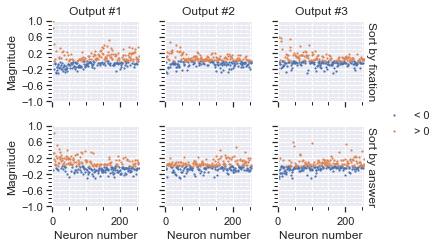

In [43]:
indexes_for_sort_fixation = [*range(hidden_size)]
indexes_for_sort_answer = [*range(hidden_size)]
indexes_for_sort_fixation = sort_elemnts_by_another(
    fixations_group_mean, indexes_for_sort_fixation
)
indexes_for_sort_answer = sort_elemnts_by_another(
    answers_group_mean, indexes_for_sort_answer
)
for name, params in model.named_parameters():
    if name == "exp_f.linear.weight":
        weights = torch.clone(params.detach()).cpu().numpy().T
        break
weights = [weights[:, i] for i in range(0, 3)]
weights_sort_by_fixation = [np.zeros_like(el) for el in weights]
weights_sort_by_answer = [np.zeros_like(el) for el in weights]
for i in range(len(weights_sort_by_fixation)):
    for j in range(hidden_size):
        weights_sort_by_answer[i][j] = weights[i][
            indexes_for_sort_answer[j]
        ]  # * answers_group_mean[
        # indexes_for_sort_answer[j]]
        weights_sort_by_fixation[i][j] = weights[i][
            indexes_for_sort_fixation[j]
        ]  # * fixations_group_mean[
        # indexes_for_sort_fixation[j]]

merge_weights = np.concatenate(
    (np.concatenate(weights_sort_by_fixation), np.concatenate(weights_sort_by_answer))
)
merge_weights[: len(merge_weights) // 2] /= merge_weights[
    : len(merge_weights) // 2
].max()
merge_weights[len(merge_weights) // 2 :] /= merge_weights[
    len(merge_weights) // 2 :
].max()
hue = (
    -(abs(merge_weights) > 1e-5).astype("int")
    + (abs(merge_weights) <= 1e-5).astype("int")
    - (merge_weights < -1e-5).astype("int")
)
hue_str = np.array(["Closed to zero"] * hue.shape[0])
hue_str[np.where(hue == -2)] = "< 0"
hue_str[np.where(hue == -1)] = "> 0"
hue_str[np.where(hue == 1)] = "Close to zero"
sorted_input_weights = pd.DataFrame(
    {
        "Data": merge_weights,
        "Sort by": ["fixation"] * len(weights_sort_by_fixation) * hidden_size
        + ["answer"] * len(weights_sort_by_fixation) * hidden_size,
        "Name": (["1"] * hidden_size + ["2"] * hidden_size + ["3"] * hidden_size) * 2,
        "Hue": hue_str,
        "x": [*range(hidden_size)] * len(weights_sort_by_fixation) * 2,
    }
)
sns.set(rc={"xtick.bottom": True, "ytick.left": True})

g = sns.FacetGrid(
    sorted_input_weights,
    col="Name",
    hue="Hue",
    row="Sort by",
    margin_titles=True,
    height=1.8,
    palette="deep",
)
# ax = g.map(sns.barplot, "x", "Data", order=sorted_input_weights.x.unique())
# ax = g.map(sns.lineplot, "x", "Data", linewidth=1, linestyle='--')\
ax = g.map(sns.scatterplot, "x", "Data", s=5.0, linewidth=0.0)
g.set_axis_labels("Neuron number", "Magnitude")
g.figure.subplots_adjust(wspace=0.3, hspace=0.3)
# g.set(xticks=[*range(0, hidden_size + 100, 100)], yticks=[*range(0, 1501, 500)], xlim=[300, 600], ylim=[0, 1000])
plt.minorticks_on()
for axes in g.axes.flat:
    axes.set_yticks(
        which="minor",
        ticks=np.arange(-1, 1.4, 0.4),
        alpha=1,
    )
    axes.set_xticks(
        which="minor",
        ticks=np.arange(0, 800, 200),
    )
    axes.set_ylim(-1, 1)
    axes.set_xlim(0, hidden_size)
    axes.grid(which="minor", linestyle="--")
g.add_legend()
g.set_titles(col_template="Output #{col_name}", row_template="Sort by {row_name}")
g.legend.set_title("")
plt.savefig("Output_sort.eps")
plt.show()

In [53]:
hue_str

'ss'

In [17]:
hue

(array([ 1,  1,  1, ..., -2, -2, -2]),)

In [348]:
test_data = pd.DataFrame()
test_data["2"] = [1, 2]
test_data["1"] = [1, 3]
test_data["1"].append([1, 2])

C:\Users\slava\AppData\Local\Temp\ipykernel_2480\1984357030.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data['1'].append([1, 2])


TypeError: cannot concatenate object of type '<class 'int'>'; only Series and DataFrame objs are valid

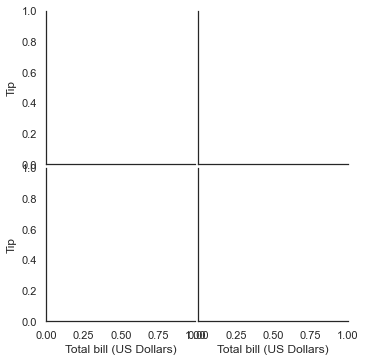

In [50]:
import seaborn as sns
import pandas as pd

# Apply the default theme
sns.set_theme()
data = pd.DataFrame(
    {
        "in_0": sort_input_weights[0],
        "in_1": sort_input_weights[1],
        "in_2": sort_input_weights[2],
    }
)
# Load an example dataset
tips = sns.load_dataset("tips")

# Create a visualization
with sns.axes_style("white"):
    g = sns.FacetGrid(tips, row="", col="smoker", margin_titles=True, height=2.5)

g.figure.subplots_adjust(wspace=0.02, hspace=0.02)
g.set_axis_labels("", "Tip")

In [53]:
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [47]:
type(tips)

pandas.core.frame.DataFrame

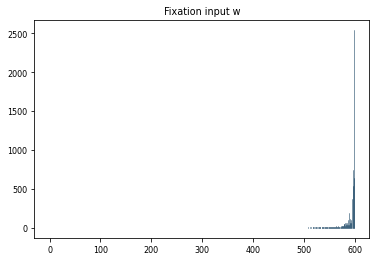

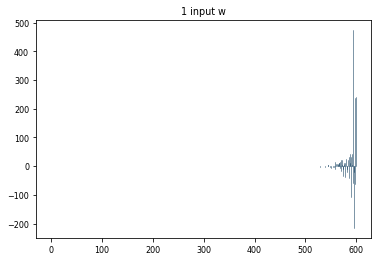

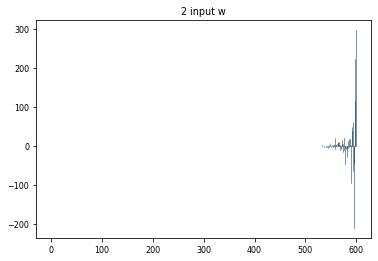

In [38]:
plt.title("Fixation input w")
plot_hist(sort_input_weights[0])
plt.show()
plt.close()
plt.title("1 input w")
plot_hist(sort_input_weights[1])
plt.show()
plt.close()
plt.title("2 input w")
plot_hist(sort_input_weights[2])
plt.show()
plt.close()

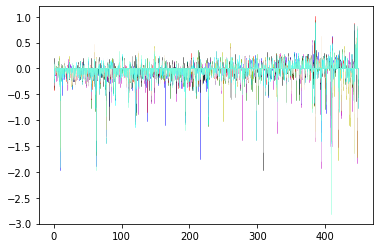

In [67]:
cmap = plt.cm.Spectral
import matplotlib.colors as mcolors

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
colors = [key for key in colors]
for i in range(3, len(sort_input_weights)):
    plot_hist(sort_input_weights[i], c=colors[i - 3])
plt.show()
plt.close()

In [64]:
import matplotlib.colors as mcolors

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
colors = [key for key in colors]

In [65]:
colors

['b',
 'g',
 'r',
 'c',
 'm',
 'y',
 'k',
 'w',
 'aliceblue',
 'antiquewhite',
 'aqua',
 'aquamarine',
 'azure',
 'beige',
 'bisque',
 'black',
 'blanchedalmond',
 'blue',
 'blueviolet',
 'brown',
 'burlywood',
 'cadetblue',
 'chartreuse',
 'chocolate',
 'coral',
 'cornflowerblue',
 'cornsilk',
 'crimson',
 'cyan',
 'darkblue',
 'darkcyan',
 'darkgoldenrod',
 'darkgray',
 'darkgreen',
 'darkgrey',
 'darkkhaki',
 'darkmagenta',
 'darkolivegreen',
 'darkorange',
 'darkorchid',
 'darkred',
 'darksalmon',
 'darkseagreen',
 'darkslateblue',
 'darkslategray',
 'darkslategrey',
 'darkturquoise',
 'darkviolet',
 'deeppink',
 'deepskyblue',
 'dimgray',
 'dimgrey',
 'dodgerblue',
 'firebrick',
 'floralwhite',
 'forestgreen',
 'fuchsia',
 'gainsboro',
 'ghostwhite',
 'gold',
 'goldenrod',
 'gray',
 'green',
 'greenyellow',
 'grey',
 'honeydew',
 'hotpink',
 'indianred',
 'indigo',
 'ivory',
 'khaki',
 'lavender',
 'lavenderblush',
 'lawngreen',
 'lemonchiffon',
 'lightblue',
 'lightcoral',
 'ligh

In [71]:
answers_np

NameError: name 'answers_np' is not defined